In [15]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

In [16]:
#generate the sample
def gen_data():
    nobs = 5000
    beta = 3
    x = np.random.uniform(low=-3., high=3., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,nobs

In [17]:
def compute_llr(yn,xn):
    
    model1 = sm.Probit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    model2 = sm.Logit(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)


yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(2.464977141479096, 0.019852097119086313)


False
False


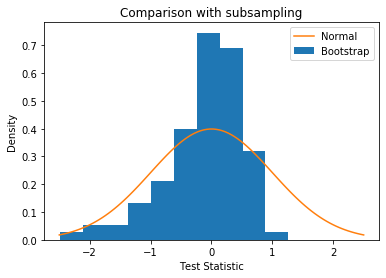

In [18]:
def regular_test(yn,xn,nobs,hist=False):
    llr, omega = compute_llr(yn,xn)
    test_stat = llr/(omega*np.sqrt(nobs))
    #plot
    if hist:
        x = np.linspace(-2.5, 2.5, 100)
        plt.plot(x, stats.norm.pdf(x, 0, 1),label="Normal")
    
    return np.abs(test_stat) >= 1.96


def bootstrap_test(yn,xn,nobs,hist=False):
    
    test_stats = []
    
    trials = 100
    for i in range(trials):
        subn = 1000
        np.random.seed()
        sample  = np.random.choice(np.arange(0,nobs),subn,replace=False)
        ys,xs = yn[sample],xn[sample]
        
        llr, omega = compute_llr(ys,xs)
        test_stat =  llr/(omega* np.sqrt(subn)) 
        
        test_stats.append(test_stat)
    #plot
    llr, omega = compute_llr(yn,xn)
    test_stat = llr/(omega*np.sqrt(nobs))
    
    #plot
    if hist:
        plt.hist( (1+np.sqrt(subn/nobs))*test_stat - np.sqrt(subn/nobs)*np.array(test_stats),
                 density=True,bins=10, label="Bootstrap")
    
    cv_lower = (1+np.sqrt(subn/nobs))*test_stat - np.sqrt(subn/nobs)*np.percentile(test_stats, 97.5, axis=0)
    cv_upper = (1+np.sqrt(subn/nobs))*test_stat -  np.sqrt(subn/nobs)*np.percentile(test_stats, 2.5, axis=0)
    
    return  0 >= cv_upper or 0 <= cv_lower
    

yn,xn,nobs = gen_data()
print(bootstrap_test(yn,xn,nobs,hist=True))
print(regular_test(yn,xn,nobs,hist=True))

plt.title("Comparison with subsampling")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('figs/bootstrap_compare')
plt.show()

#http://www.stat.umn.edu/geyer/5601/notes/sub.pdf

In [19]:
reg = 0
boot = 0 
total = 100
for i in range(total):
    np.random.seed()
    yn,xn,nobs = gen_data()
    reg = regular_test(yn,xn,nobs) +reg
    boot = bootstrap_test(yn,xn,nobs) +boot

print("reg: %s, boot: %s"%(reg/total,boot/total))

reg: 0.31, boot: 0.62


In [12]:
#reg: 0.337, boot: 0.049